# Task 3 - Quanvolutional Neural Networks (QNN)

- Quanvolutional Neural Networks (QNNs) are the quantum version of the classical deep learning model known as the Convolutional Neural Network (CNN).
- Traditional CNNs use a kernel (represented as a matrix) with iterative passes through image data to reduce its dimensions until the image gets "convoluted" to the point where its pixel values can be combined to predict an output (classification/regression) using weigted nodes with bias as in a regular neural network.
- CNNs also involve pooling functions to aggregate the value of each convolutional step in the iterative process.
- The major high-level steps involved in training a QNN model involve:
    1. Data encoding: Converting the classical data into quantum data which the QNN model can be trained on (with optional additional preprocessing of classical data).
    2. Quantum convolutional layer: Involves the quantum convolution kernel, which is implemented using a parameterized quantum circuit ansatz optimized using a classical optimization algorithm.
    3. Classical training: The convolved image (which would have used classical kernel processing in the case of CNNs, but uses quantum circuit convultions in QNNs) uses its reduced (convolved) pixel values as input features to a classical neural network architecture.
- In this notebook, the implementation of a QNN is performed on the MNIST handwritten digit dataset, and its performance is compared to a raw CNN architecture.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
Preprocess = True #Flag to determine whether or not to run preprocessing on the quantum data

#Random seeds to ensure code reproducibility:
np.random.seed(0)
tf.random.set_seed(0)

### Load the Data:
- MNIST dataset is used, which consists of several labeled hand-drawn digits from humans (0-9).
- The dataset is split into training and test datasets (each containing images and labels)

In [3]:
#Load the MNIST dataset:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

#Selecting only neccesary amount of training and testing images:
#(50 train + 50 test images with labels)
train_images = train_images[:50]
train_labels = train_labels[:50]
test_images = test_images[:30]
test_labels = test_labels[:30]

#Normalization: (pixel values ranging from 0-255 mapped onto 0-1 values)
train_images = train_images / 255
test_images = test_images / 255

#Convolution channels:
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [4]:
#Create a 4-qubit device to run the quantum circuit on:
dev = qml.device('default.qubit', wires=4)

#Random circuit parameters for initialization:
rand_params = np.random.uniform(high=2 * np.pi, size=(1, 4))

#Create the QNode with the quantum circuit:
@qml.qnode(dev)
def circuit(data):
    #For each of the 4 qubits
    #Here, the data is encoded as a rotation about Y axis on each qubit
    #Hence, an RY gate is used and the normalized pixel values (data) 
    #are scaled from 0-pi rotation about Y-axis:
    for j in range(4):
        qml.RY(np.pi * data[j], wires=j)  #Map 0-1 pixel value to 0-pi rotation about Y axis for every 'jth' qubit

    #Create randomized circuit ansatz layers for all 4 qubits:
    RandomLayers(rand_params, wires=[0,1,2,3])

    #Return 4 classical information
    #This is done by computing expectation value on applying the pauliZ observable on each Y-rotated qubit:
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

- Next, a function is defined to run the quantum circuit many times, iteratively to convolve a raw input image to a reduced form.
- The hope is that the quantum-convolved image contains better generalization than the raw input data.
- This may help a traditional neural network better learn the patterns associated with different numbers (like 0/1...9).
- In this example a 2x2 quantum kernel has been chosen:

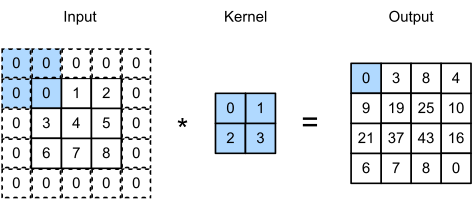

[reference: https://medium.com/codex/kernels-filters-in-convolutional-neural-network-cnn-lets-talk-about-them-ee4e94f3319]

In [5]:
def quanv(image):
    #Initialialize the output convoluted image as all 0s (with appropriate dimesnsions after convolution):
    QNN_output_img = np.zeros((14, 14, 4))

    #We know that the image size of the MNIST dataset is 28x28 pixel
    #The chosen kernel is 2x2 (see above image)
    #Hence, every iteration from the top-left most pixel (0,0) must shift the kernel 2 pixels to the right and 2 pixels down
    #i and j represent these indices:
    for i in range(0, 28, 2): #28 because of size of input; 2 increment because of size of kernel
        for j in range(0, 28, 2):
            #Apply the 2x2 quantum kernel by running the quantum circuit on the 4 image pixel values within the 2x2 kernel:
            q_results = circuit(
                [
                    #On each of the 4 adjacent pixels within 2x2 kernel:
                    image[i, j, 0],
                    image[i, j+1, 0],
                    image[i+1, j, 0],
                    image[i+1, j+1, 0]
                ]
            )
            #Store the outputted expectation values from the kernel into the output image:
            for c in range(4):
                QNN_output_img[i//2, j//2, c] = q_results[c]
    
    #Return the quanvoluted output image:
    return QNN_output_img

### Data Prepocessing Phase
- All of the earlier steps have defined:
    1. The Loading of the MNIST dataset.
    2. The quantum circuit ansatz (which encodes 4 pixel inputs as rotations along Y axis, and outputs expectation values of the PauliZ observable).
    3. The quantum data processing via quantum kernel on a 28x28 pixel input image, to generate the convolved image data.
- Now, we must:
    1. Preprocess a batch of images from the MNIST dataset using QNN.
    2. Train a classical neural network on the convolved "Quantum MNIST dataset".
    3. Train a classical neural network on the raw MNIST dataset.
    4. Evaluate and compare the performances of the QNN and direct classical NN approaches.


In [6]:
#If preprocessing not done:
#Preprocess 50 images for training and 50 images for testing using the QNN:
if Preprocess == True:
    #1) Preprocessing the training images:
    q_train_images = []
    print('Quantum pre-processing of train images:')
    for i, img in enumerate(train_images):
        #Display a current count out of 50 for the image being preprocessed:
        print("{}/{}        ".format(i+1, 50), end="\r")
        #Add the quanvoluted (quantum preprocessed) images to the training image set:
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    #2) Preprocessing the testing images: (similar steps)
    q_test_images = []
    print('\nQuantum pre-processing of test images:')
    for i, img in enumerate(test_images):
        print('{}/{}        '.format(i+1, 30), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


In [7]:
if Preprocess == True:
    #Save the quantum-preprocessed images (using numpy):
    np.save('data'+'q_train_images.npy', q_train_images)
    np.save('data'+'q_test_images.npy', q_test_images)


    #Load the quantum-preprocessed images:
    q_train_images = np.load('data' + 'q_train_images.npy')
    q_test_images = np.load('data' + 'q_test_images.npy')

NOTE:
- I initially had the question of why we were saving and reloading the preprocessed images in spite of having access to the train and test set in the code.
- The reason for doing this is that in most applications, the preparation and preprocessing of data is done separately to the model training and testing processes. Thus, it is practice to save the data, which can be used a later time, or by another person/program for model training and testing purposes.

#### Visualizing the impact of the iterative application of the quantum convolutional layers
It can be observed that as more kernel processing occurs, the image becomes more convoluted (less defined), but preserved the general features of the original input image

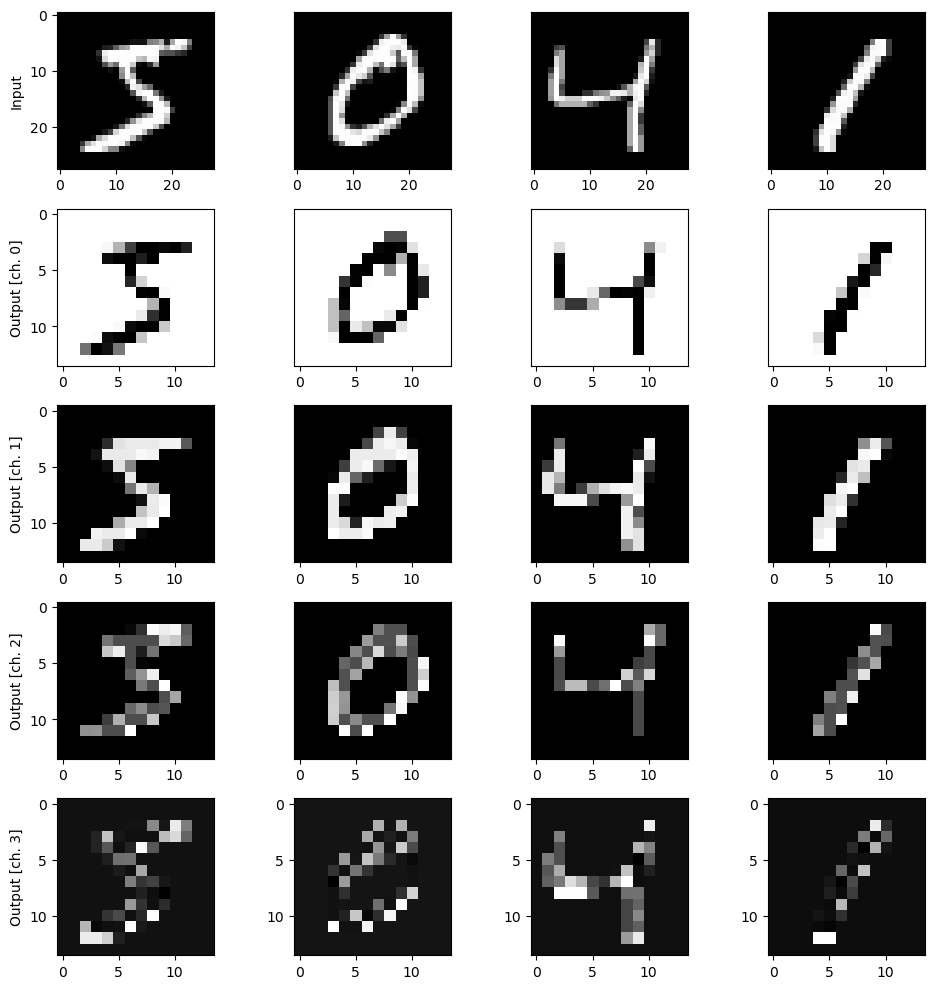

In [8]:
n_samples = 4 #Number of images to sample and observe
n_channels = 4 #Number of image channels

#Visualization:
#Create a subplot (figure) with 5 rows (input + 4 iterations) and 4 columns (4 sample images):
fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))

#For each of the 4 samples:
for i in range(n_samples):
    #Label 1st row as input:
    axes[0, 0].set_ylabel('Input')
    #Only show y axis demarcations for 1st image:
    if i!=0:
        axes[0, i].yaxis.set_visible(False)
    #Display the grayscale image of 'ith' raw input image:
    axes[0, i].imshow(train_images[i, :, :, 0], cmap="gray")

    #Plot channels after applying quantum kernel convolutions on the raw image (4 iterations):
    for c in range(n_channels):
        #Set the row's label as the channl number:
        axes[c+1, 0].set_ylabel('Output [ch. {}]'.format(c))
        #Only show y axis for 1st image:
        if i != 0:
            axes[c, i].yaxis.set_visible(False)
        #Display the grayscale convoluted image through quantum kernel:
        axes[c+1, i].imshow(q_train_images[i, :, :, c], cmap='gray')

#Show the plot:
plt.tight_layout()
plt.show()

### Model Creation
- A classical machine learning model for the image classification is created using the keras framework.
- It consists of a sinple sequential neural network architecture with 10 output neurons (corresponding to 0-9), which uses a softmax function for value aggregation from previous layers.
- Here, flatten serves the purpose of encoding input into a 1D vector that may be passed into the model

In [9]:
def MNISTClassificationModel():
    model = keras.models.Sequential([
        keras.layers.Flatten(), #Encode data as a 1D vector
        keras.layers.Dense(10, activation='softmax') #Aggregate values using softmax for label prediction
    ])

    #Compile the model:
    model.compile(
        optimizer='adam', #Adam optimizer used as an optimization algorithm for gradient descent
        loss='sparse_categorical_crossentropy', #Sparse categorical entropy used as a loss/cost function to quantify error rate of predictions
        metrics=['accuracy'], #Accuracy used as a performance metric for model evaluation and comparison
    )
    return model

### Training Classical Model on Preprocessed Data using Quantum Kernel

In [10]:
#Instantiate a classical classifier model:
q_model = MNISTClassificationModel()

#Train the classical classifier on the quantum-preprocessed training dataset:
q_history = q_model.fit(
    q_train_images, #Input features (quanvoluted MNIST images)
    train_labels, #Training labels corresponding to the preprocessed images
    validation_data=(q_test_images, test_labels), #Validate model performance using test data
    batch_size=4, #4 images per batch
    epochs= 30, #30 epochs (i.e. generations of training and validation until loss of the model converges)
    verbose=2, #Just to display the epoch number during training
)



Epoch 1/30


13/13 - 3s - loss: 2.7082 - accuracy: 0.1600 - val_loss: 2.3569 - val_accuracy: 0.3333 - 3s/epoch - 198ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0751 - accuracy: 0.2800 - val_loss: 2.1523 - val_accuracy: 0.2667 - 101ms/epoch - 8ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6568 - accuracy: 0.5400 - val_loss: 1.9466 - val_accuracy: 0.3667 - 171ms/epoch - 13ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3097 - accuracy: 0.6800 - val_loss: 1.7915 - val_accuracy: 0.4667 - 88ms/epoch - 7ms/step
Epoch 5/30
13/13 - 0s - loss: 1.0989 - accuracy: 0.8200 - val_loss: 1.6803 - val_accuracy: 0.4667 - 98ms/epoch - 8ms/step
Epoch 6/30
13/13 - 0s - loss: 0.9246 - accuracy: 0.8400 - val_loss: 1.5797 - val_accuracy: 0.5000 - 122ms/epoch - 9ms/step
Epoch 7/30
13/13 - 0s - loss: 0.7498 - accuracy: 0.9000 - val_loss: 1.4862 - val_accuracy: 0.6000 - 115ms/epoch - 9ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6288 - accuracy: 0.9400 - val_loss: 1.4397 - val_accuracy: 0.6000 - 134ms/epoch - 10ms/step
Epoch 9/30
13

As can be observed, after 30 epochs of training, the model trained on the quantum-preprocess data converges to:
- Loss ~ 0.0813
- Accuracy ~ 1.0000
- Validation Loss ~ 1.0476
- Validation Accuracy ~ 0.7000

Now, let us train a classical classifier on the raw MNIST dataset and compare their performances with the QNN approach.

### Training Classical Model on The Raw, Unprocessed MNIST Dataset 

In [11]:
#Instantiate a classical classification model:
c_model = MNISTClassificationModel()

#Train the classicial classifier on the raw, unprocessed images in the MNIST dataset:
c_history = c_model.fit(
    train_images, #Raw training images
    train_labels, #Training labels
    validation_data=(test_images, test_labels), #Using test data for performance validation
    batch_size=4, #4 images per batch
    epochs= 30, #30 epochs of learning
    verbose=2, #Display epoch numbers
)

Epoch 1/30
13/13 - 1s - loss: 2.2495 - accuracy: 0.1200 - val_loss: 2.1271 - val_accuracy: 0.1667 - 944ms/epoch - 73ms/step
Epoch 2/30
13/13 - 0s - loss: 1.8881 - accuracy: 0.4400 - val_loss: 1.9734 - val_accuracy: 0.2667 - 110ms/epoch - 8ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6068 - accuracy: 0.6400 - val_loss: 1.8370 - val_accuracy: 0.5333 - 108ms/epoch - 8ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3777 - accuracy: 0.8000 - val_loss: 1.7193 - val_accuracy: 0.5000 - 105ms/epoch - 8ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1832 - accuracy: 0.8800 - val_loss: 1.6110 - val_accuracy: 0.6000 - 132ms/epoch - 10ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0272 - accuracy: 0.9200 - val_loss: 1.5254 - val_accuracy: 0.6333 - 140ms/epoch - 11ms/step
Epoch 7/30
13/13 - 0s - loss: 0.8952 - accuracy: 0.9400 - val_loss: 1.4593 - val_accuracy: 0.6333 - 99ms/epoch - 8ms/step
Epoch 8/30
13/13 - 0s - loss: 0.7842 - accuracy: 0.9400 - val_loss: 1.3980 - val_accuracy: 0.6000 - 96ms/epoch - 7ms/step
Epoch 9/30
13/1

After 30 epochs of training, the classical model trained on the unprocessed data converges to:
- Loss ~ 0.1316
- Accuracy ~ 1.0000
- Validation Loss ~ 1.0143
- Validation Accuracy ~ 0.7000

With minor performance variation, and the probabilistic nature of these algorithms, it can be safely concluded that the performance of both the unprocessed and QNN preprocessing approaches yield similar accuracies and similar losses.

#### Plotting Accuracies and Loss of the QNN Model and Classical Model vs Number of Epochs 

C:\Users\drarc\AppData\Local\Temp\ipykernel_20156\925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


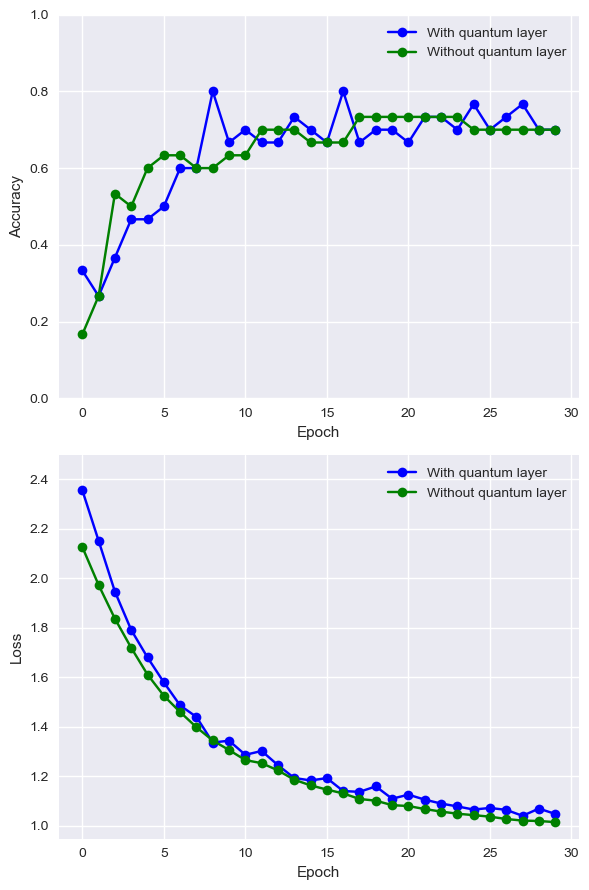

In [12]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
#Create 2 plots (2 row, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

#Plot 1: (Accuracy vs no. of epochs)
#Plot the QNN validation accuracies, using blue dots with lines, labeled 'With quantum layer': 
ax1.plot(q_history.history['val_accuracy'], '-ob', label='With quantum layer')
#Plot the classical validation accuries, using green dots with lines, labeled 'Without quantum layer':
ax1.plot(c_history.history['val_accuracy'], '-og', label='Without quantum layer')
#Plot accuracy vs epoch:
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0, 1]) #0-1 range of accuracy
ax1.set_xlabel('Epoch')
ax1.legend() #Add a legend

#Plot 2: (Loss vs no. of epochs) -> Similar method:
#Plot QNN validation losses:
ax2.plot(q_history.history['val_loss'], '-ob', label='With quantum layer')
#Plot classical validation losses:
ax2.plot(c_history.history['val_loss'], '-og', label='Without quantum layer')
#Plot the loss vs epochs graph:
ax2.set_ylabel('Loss')
ax2.set_ylim(top=2.5)
ax2.set_xlabel('Epoch')
ax2.legend()

#Display both graphs:
plt.tight_layout()
plt.show()

### Conclusion
- Hence, a quantum neural network was learnt about and implemented in Task-3. 
- It involved loading image data from a well-known MNIST dataset. 
- Following this, a randomized quantum circuit with 4 qubits was used as an ansatz, which encoded normalized input grayscaled pixel values as rotations of 4 qubits about the Y axis and output being the expectation value of the Pauli Z observable on the qubits.
- These 4 qubits behave as a 2x2 "quantum kernel", which convolutes the input images, much like how a classical CNN convolutes its images into more generalized feautures.
- This quantum kernel was then applied to 80 images (50 train + 30 test) of the MNIST dataset to preprocess the images.
- Following this, a classical neural network architecture was trained on the quantum preprocessed MNIST dataset, as well as the raw, unprocessed dataset independently, and their performances were compared.
- After execution, it was found that there was no significant difference or improvement in the prediction performance, even inspite of applying quantum preprocessing the dataset.